### Kalman Filter Implementation

In [1]:
import numpy as np
from dataclasses import dataclass
from enum import Enum
from typing import Callable

class KalmanFilter:
    
    @dataclass
    class KalmanState:
        mean: np.ndarray
        covariance: np.ndarray

        def copy(self):
            return KalmanFilter.KalmanState(self.mean.copy(), self.covariance.copy())

    state: KalmanState
    
    def __init__(self, initial_state: KalmanState,
                 get_prediction_mat: Callable[[KalmanState, float], np.ndarray],
                 get_sensor_mat: Callable[[KalmanState], np.ndarray],
                 process_noise_mat: np.ndarray | None=None):
        self.state = initial_state
        self.get_prediction_mat = get_prediction_mat
        self.get_sensor_mat = get_sensor_mat
        self.process_noise_mat = process_noise_mat


    def predict(self, timestep: float) -> None:
        """"Update beliefs due to the passasge of time"""
        prediction_mat = self.get_prediction_mat(self.state, timestep)

        self.state.mean = prediction_mat @ self.state.mean
        self.state.covariance = prediction_mat @ self.state.covariance @ prediction_mat.transpose()

        if self.process_noise_mat is not None:
            self.state.covariance += self.process_noise_mat


    def process_measurement(self, measurement: np.ndarray, measurement_var: np.ndarray) -> None:
        """Update beliefs when new measurements are made"""
        sensor_mat = self.get_sensor_mat(self.state)

        kalman_gain = self.state.covariance @ sensor_mat.transpose() @ np.linalg.inv(sensor_mat @ self.state.covariance @ sensor_mat.transpose() + measurement_var)
        
        self.state.mean = self.state.mean + kalman_gain @ (measurement - sensor_mat @ self.state.mean)
        self.state.covariance = self.state.covariance - kalman_gain @ sensor_mat @ self.state.covariance


    def update(self, timestep: float, measurement: np.ndarray, measurement_var: np.ndarray) -> KalmanState:
        self.predict(timestep)

        self.process_measurement(measurement, measurement_var)

        return self.state


### Kalman Tester
Test harness for simulating a system and recording the filter's predictions at each step

In [2]:
class KalmanTester:

    @dataclass
    class KalmanTestResult:
        timesteps: np.ndarray
        states: list[np.ndarray]
        estimates: list[KalmanFilter.KalmanState]
        measurements: list[np.ndarray]

    # Defines the different types of sensors and their measurement frequencies
    measurement_type: dict[str, float]

    def __init__(self, filter: KalmanFilter):
        self.filter = filter

    @staticmethod
    def update_dynamics(timestep: float, last_state: np.ndarray) -> np.ndarray:
        raise NotImplementedError
    
    @staticmethod
    def get_measurement(state: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        raise NotImplementedError

    def run(self, timestep: float, steps: int, initial_state: np.ndarray) -> KalmanTestResult:
        """Run a simulation to test the Kalman filter"""
        system_state = initial_state
        states: list[np.ndarray] = []
        measurements: list[np.ndarray] = []
        estimates: list[KalmanFilter.KalmanState] = []

        for _ in range(steps):
            # Simulate dynamics
            system_state = self.update_dynamics(timestep, system_state)
            states.append(system_state)

            # Simulate measurement
            measurement, measurment_covar = self.get_measurement(system_state)
            measurements.append(np.array([measurement]))

            # Apply Kalman filter
            state_estimate = self.filter.update(timestep, measurement, measurement_var=measurment_covar)
            estimates.append(state_estimate.copy())

        return KalmanTester.KalmanTestResult(np.arange(0, timestep * steps, timestep), states, estimates, measurements)

### Plotting Utilities

In [3]:
import matplotlib.pyplot as plt

def kalman_plot_1d(result: KalmanTester.KalmanTestResult, state_idx: int, measurement_idx=None,
                   true_label="True State", prediction_label="Kalman Prediction", measurement_label="Measurements",
                   xlabel="Time (s)", ylabel="State", title="Kalman Filter Prediction",
                   ax=None, plot_confidence=True):
    if ax is None:
        _, ax = plt.subplots()

    ax.plot(result.timesteps, [v[state_idx] for v in result.states], label=true_label)

    ax.plot(result.timesteps, [e.mean[state_idx] for e in result.estimates], color="orange", label=prediction_label)

    if measurement_idx is not None:
        ax.scatter(result.timesteps, [m[measurement_idx] for m in result.measurements], c='r', label=measurement_label)
    
    if plot_confidence:
        ax.fill_between(
            result.timesteps,
            [e.mean[state_idx] + 2 * np.sqrt(e.covariance[state_idx, state_idx]) for e in result.estimates],
            [e.mean[state_idx] - 2 * np.sqrt(e.covariance[state_idx, state_idx]) for e in result.estimates],
            color='orange',
            alpha=0.15,
        )

    ax.legend()
    # ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

### 1d Radar Tracking Example

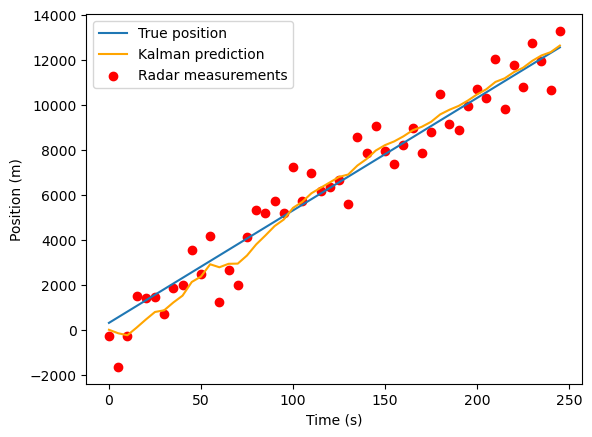

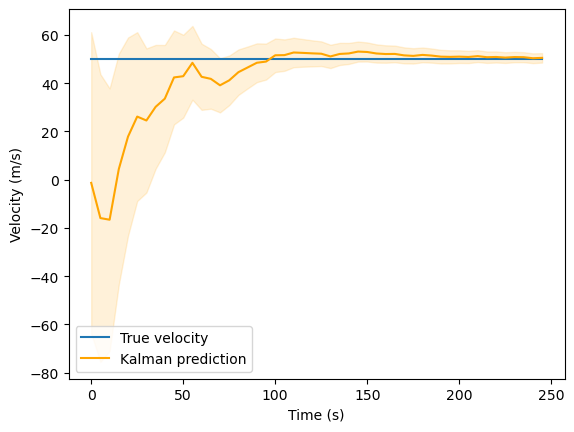

In [4]:
from scipy.stats import norm

SIMULATION_STEPS = 50
TIME_STEP = 5  # s
PLANE_VEL = 50  # m/s
RADAR_STD_DEV = 1000  # Meters

class RadarTrackingTester(KalmanTester):

    class StateVariables(Enum):
        POSITION = 0
        VELOCITY = 1

    measurement_types = {
        "radar": 5
    }

    def __init__(self):
        # Initialize Kalman filter with large variances to model uncertain starting conditions
        filter = KalmanFilter(
            KalmanFilter.KalmanState(
                mean=np.array([0, 0], dtype=np.float64),
                covariance=np.array([[1000, 0], [0, 1000]], dtype=np.float64)
            ),
            get_prediction_mat=self.get_prediction_mat,
            get_sensor_mat=self.get_sensor_mat
        )
        super().__init__(filter)

    @staticmethod
    def update_dynamics(timestep: float, last_state: np.ndarray) -> np.ndarray:
        return np.array([
            last_state[RadarTrackingTester.StateVariables.POSITION.value] + last_state[RadarTrackingTester.StateVariables.VELOCITY.value] * timestep,
            last_state[RadarTrackingTester.StateVariables.VELOCITY.value]  # Constant velocity
        ])


    @staticmethod
    def get_measurement(state: np.ndarray) -> float:
        measurement_dist = norm(loc=state[RadarTrackingTester.StateVariables.POSITION.value], scale=RADAR_STD_DEV)
        return measurement_dist.rvs(), np.array([[RADAR_STD_DEV ** 2]])  # Variance of the measurement

    @staticmethod
    def get_prediction_mat(state: KalmanFilter.KalmanState, timestep: float) -> np.ndarray:
        return np.array([[1, timestep], [0, 1]])

    @staticmethod
    def get_sensor_mat(state: KalmanFilter.KalmanState) -> np.ndarray:
        return np.array([[1, 0]])  # Radar measures position only


initial_state = np.array([
    50,  # Arbitrary starting position
    PLANE_VEL
])

radar_tester = RadarTrackingTester()
result = radar_tester.run(TIME_STEP, SIMULATION_STEPS, initial_state)


kalman_plot_1d(result, RadarTrackingTester.StateVariables.POSITION.value,
               measurement_idx=0,
               true_label="True position", prediction_label="Kalman prediction",
               measurement_label="Radar measurements",
               xlabel="Time (s)", ylabel="Position (m)",
               title="Kalman Position Prediction",
               plot_confidence=False
               )

kalman_plot_1d(result, RadarTrackingTester.StateVariables.VELOCITY.value,
               true_label="True velocity", prediction_label="Kalman prediction",
               xlabel="Time (s)", ylabel="Velocity (m/s)",
               title="Kalman Velocity Prediction",
               plot_confidence=True
               )


### Deviation From Kalman Model

In [5]:
class PoorRadarModel(RadarTrackingTester):
    @staticmethod
    def update_dynamics(timestep: float, last_state: np.ndarray, time: float) -> np.ndarray:
        return np.array([
            last_state[RadarTrackingTester.StateVariables.POSITION.value] + last_state[RadarTrackingTester.StateVariables.VELOCITY.value] * timestep,
            last_state[RadarTrackingTester.StateVariables.VELOCITY.value] + 0.5 * timestep  # Constant acceleration
        ])
    
poor_tester = PoorRadarModel()
result = poor_tester.run(TIME_STEP, SIMULATION_STEPS, initial_state)


kalman_plot_1d(result, PoorRadarModel.StateVariables.POSITION.value,
               measurement_idx=0,
               true_label="True position", prediction_label="Kalman prediction",
               measurement_label="Radar measurements",
               xlabel="Time (s)", ylabel="Position (m)",
               title="Poorly Aligned Position Prediction",
               plot_confidence=False
               )

kalman_plot_1d(result, RadarTrackingTester.StateVariables.VELOCITY.value,
               true_label="True velocity", prediction_label="Kalman prediction",
               xlabel="Time (s)", ylabel="Velocity (m/s)",
               title="Poorly Aligned Velocity Prediction",
               plot_confidence=True
               )

class RadarModelWithProcessNoise(PoorRadarModel):
    def __init__(self):
        filter = KalmanFilter(
            KalmanFilter.KalmanState(
                mean=np.array([0, 0], dtype=np.float64),
                covariance=np.array([[1000, 0], [0, 1000]], dtype=np.float64)
            ),
            get_prediction_mat=self.get_prediction_mat,
            get_sensor_mat=self.get_sensor_mat,
            process_noise_mat=np.array([[1e2, 0], [0, 1e2]], dtype=np.float64)
        )
        KalmanTester.__init__(self, filter)

process_noise_tester = RadarModelWithProcessNoise()
result = process_noise_tester.run(TIME_STEP, SIMULATION_STEPS, initial_state)

kalman_plot_1d(result, RadarModelWithProcessNoise.StateVariables.POSITION.value,
               measurement_idx=0,
               true_label="True position", prediction_label="Kalman prediction",
               measurement_label="Radar measurements",
               xlabel="Time (s)", ylabel="Position (m)",
               title="Position Prediction with Process Noise",
               plot_confidence=False
               )

kalman_plot_1d(result, RadarTrackingTester.StateVariables.VELOCITY.value,
               true_label="True velocity", prediction_label="Kalman prediction",
               xlabel="Time (s)", ylabel="Velocity (m/s)",
               title="Velocity Prediction with Process Noise",
               plot_confidence=True
               )


TypeError: PoorRadarModel.update_dynamics() missing 1 required positional argument: 'time'

### 2d Robot Localization

In [ ]:
# GPS_STD_DEV = 1  # Meters

# class RobotLocalzationTester(KalmanTester):

#     class StateVariables(Enum):
#         X_POSITION = 0
#         Y_POSITION = 1
#         HEADING = 2
#         ANGULAR_VELOCITY = 3
#         SPEED = 4

#     def __init__(self):
#         # Initialize Kalman filter with large variances to model uncertain starting conditions
#         filter = KalmanFilter(
#             KalmanFilter.KalmanState(
#                 mean=np.array([0, 0, 0, 0, 0], dtype=np.float64),
#                 covariance=np.diag([1000, 1000, 1000, 1000, 1000], dtype=np.float64)
#             ),
#             get_prediction_mat=self.get_prediction_mat,
#             get_sensor_mat=self.get_sensor_mat
#         )
#         super().__init__(filter)

#     @staticmethod
#     def update_dynamics(timestep: float, last_state: np.ndarray, time: float) -> np.ndarray:
#         vars = RobotLocalzationTester.StateVariables
#         return np.array([
#             vars.X_POSITION.value + last_state[vars.SPEED.value] * np.cos(last_state[vars.HEADING.value]) * timestep,
#             vars.Y_POSITION.value + last_state[vars.SPEED.value] * np.sin(last_state[vars.HEADING.value]) * timestep,
#             vars.HEADING.value + last_state[vars.ANGULAR_VELOCITY.value] * timestep,
#             vars.ANGULAR_VELOCITY.value,  # Constant angular velocity
#             vars.SPEED.value  # Constant speed
#         ])


#     @staticmethod
#     def get_measurement(state: np.ndarray, time: float) -> float:
#         measurement_dist = norm(loc=state[RadarTrackingTester.StateVariables.POSITION.value], scale=RADAR_STD_DEV)
#         return measurement_dist.rvs(), np.array([[RADAR_STD_DEV ** 2]])  # Variance of the measurement

#     @staticmethod
#     def get_prediction_mat(state: KalmanFilter.KalmanState, timestep: float) -> np.ndarray:
#         return np.array([[1, timestep], [0, 1]])

#     @staticmethod
#     def get_sensor_mat(state: KalmanFilter.KalmanState, time: float) -> np.ndarray:
#         return np.array([[1, 0]])  # Radar measures position only


# initial_state = np.array([
#     50,  # Arbitrary starting position
#     PLANE_VEL
# ])

# radar_tester = RadarTrackingTester()
# result = radar_tester.run(TIME_STEP, SIMULATION_STEPS, initial_state)


# kalman_plot_1d(result, RadarTrackingTester.StateVariables.POSITION.value,
#                measurement_idx=0,
#                true_label="True position", prediction_label="Kalman prediction",
#                measurement_label="Radar measurements",
#                xlabel="Time (s)", ylabel="Position (m)",
#                title="Kalman Position Prediction",
#                plot_confidence=False
#                )

# kalman_plot_1d(result, RadarTrackingTester.StateVariables.VELOCITY.value,
#                true_label="True velocity", prediction_label="Kalman prediction",
#                xlabel="Time (s)", ylabel="Velocity (m/s)",
#                title="Kalman Velocity Prediction",
#                plot_confidence=True
#                )